In [1]:
# Always a bit risky, but I think the chance for name space convolution is small 
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from plotnine import *
import warnings
warnings.filterwarnings("ignore")
# For handling dates 
from mizani.breaks import date_breaks
from mizani.formatters import date_format

# A nice color palette for categorical data 
cbPalette = ["#E69F00", "#56B4E9", "#009E73", 
             "#0072B2", "#D55E00", 
             "#CC79A7", "#F0E442", "#999999"]

# Proportions when saving figures 
BASE_HEIGHT = 5
BASE_WIDTH = 7.0

# Directory for saving figures
dir_save = "./Figs/"
if not os.path.isdir(dir_save):
    os.mkdir(dir_save)

Let us start with fixing the bad example. The problem here is that the seasonal aspect is not considered in the original plot. As seen below, Spain has lower unemployment in summer.

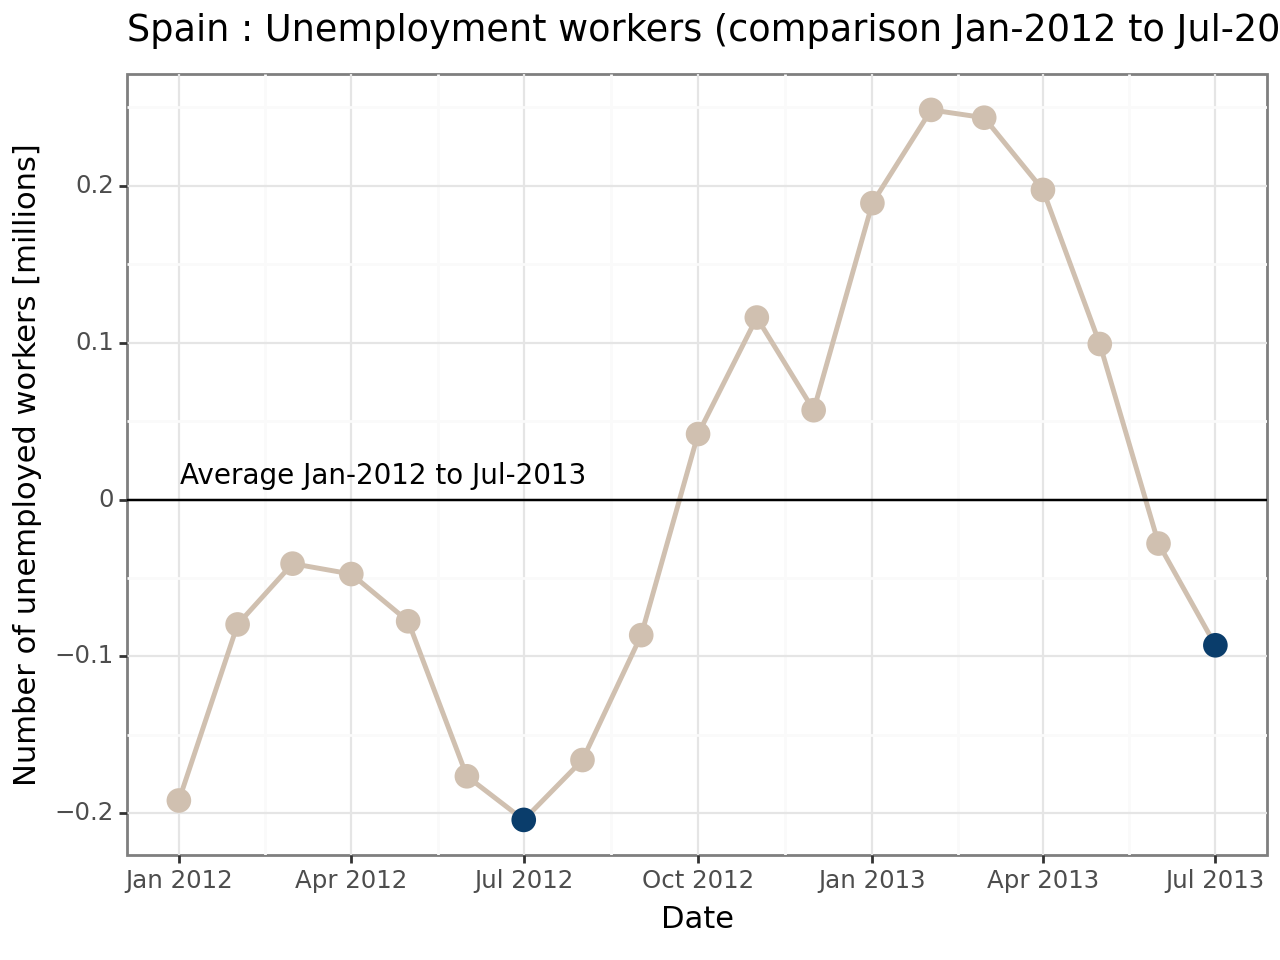

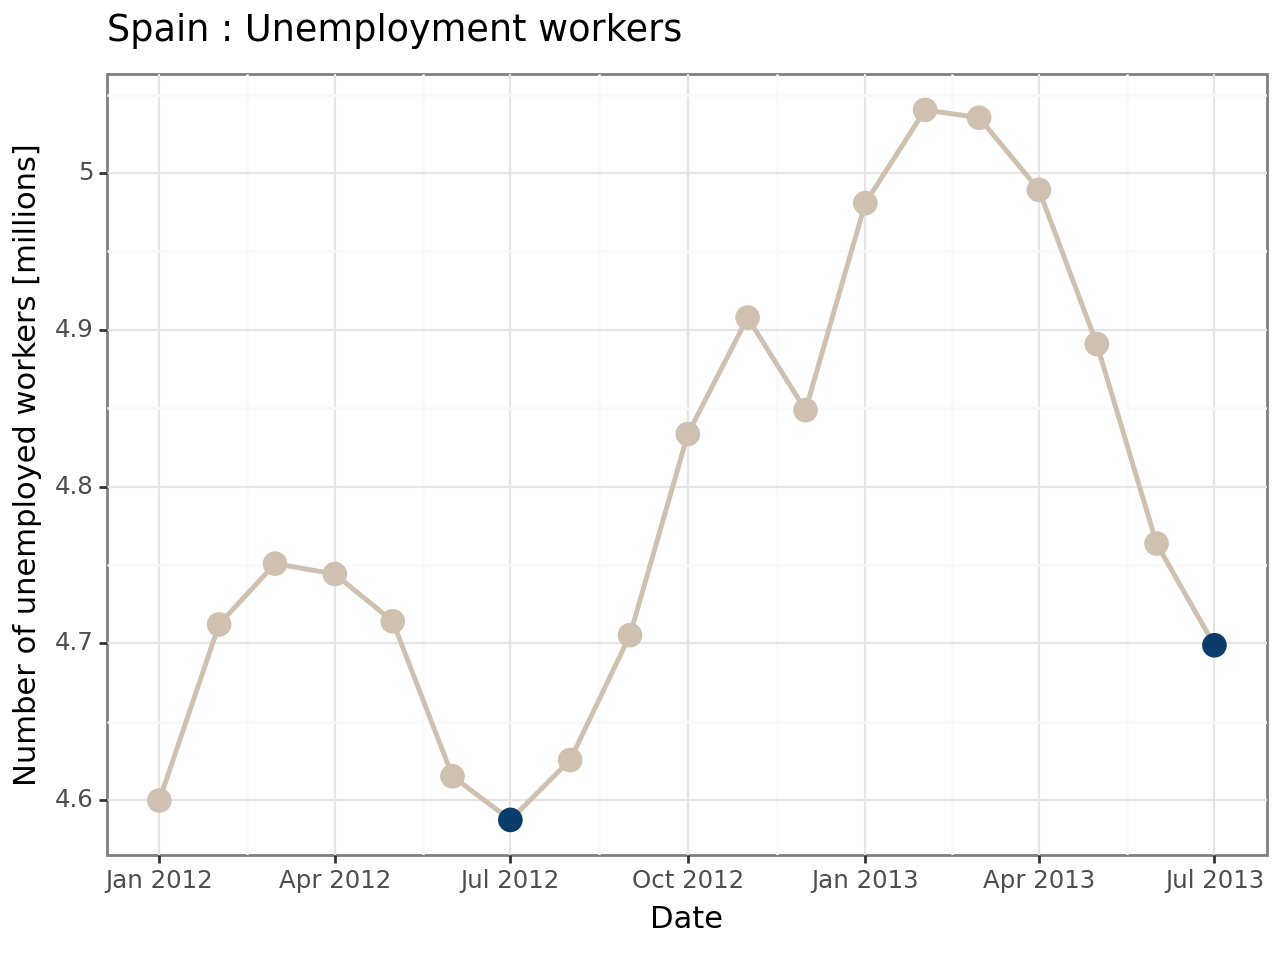

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [2]:

data_spain = pd.read_csv("Data/Spain_tidy.csv")

# Working with dates is always a pain 
data_2013_2014 = data_spain.query("(Year >= 2012) and DATE < '2013-07-30'")
data_2013_2014 = data_2013_2014.assign(DATE=pd.to_datetime(data_2013_2014["DATE"]))
data_2013_2014.reset_index(inplace=True)
data_2013_2014["Number_unemployed"] = data_2013_2014["Number_unemployed"] / 1e6
data_2013_2014["Index_unemployed"] = data_2013_2014["Number_unemployed"] - np.mean(data_2013_2014["Number_unemployed"])
data_2013_2014["Should_highlight"] = "Not"
data_2013_2014["Should_highlight"][data_2013_2014["Month"] == 7] = "Yes"

col_highlight = ["#D0C0B0", "#0A3D6B", "#B6C2CC", "#BEAAB4", "#ECE9CD", "#0D5C3D", "#812F02"]

p1 = (ggplot(data_2013_2014, aes("DATE", "Index_unemployed"))
    + geom_line(size=1.0, color = col_highlight[0])
    + geom_point(aes(color = "Should_highlight"), size=4.0)
    + geom_hline(yintercept=0.0)
    + annotate("text", x = '2012-04-18', y = 0.015, label = "Average Jan-2012 to Jul-2013", size=10.0)
    + scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%b %Y'))
    + scale_color_manual(values=col_highlight)
    + labs(x = "Date", y = "Number of unemployed workers [millions]", title = "Spain : Unemployment workers (comparison Jan-2012 to Jul-2013 average)")
    + theme_bw()
    + theme(legend_position="none"))

p2 = (ggplot(data_2013_2014, aes("DATE", "Number_unemployed"))
    + geom_line(size=1.0, color = col_highlight[0])
    + geom_point(aes(color = "Should_highlight"), size=4.0)
    + scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%b %Y'))
    + scale_color_manual(values=col_highlight)
    + labs(x = "Date", y = "Number of unemployed workers [millions]", title = "Spain : Unemployment workers")
    + theme_bw()
    + theme(legend_position="none"))

p1.save("Figs/Unemlpoyed_v1.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p2.save("Figs/Unemlpoyed_v2.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)

[p1, p2]

We can visualise time series data with dots, but if we have multiple categories, it is better to use lines. Notice, if we drop the points, we put larger focus on the trend.

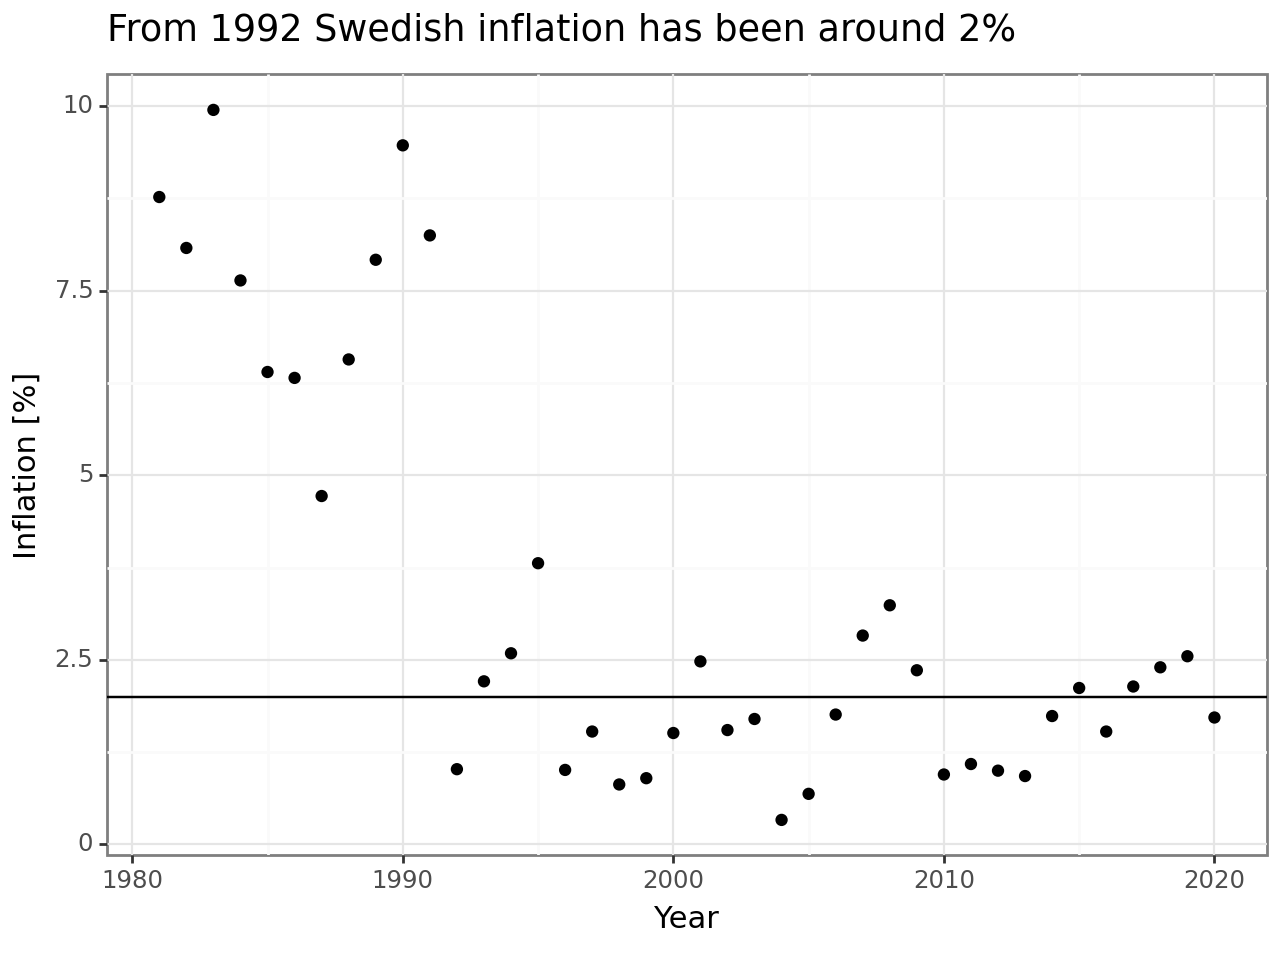

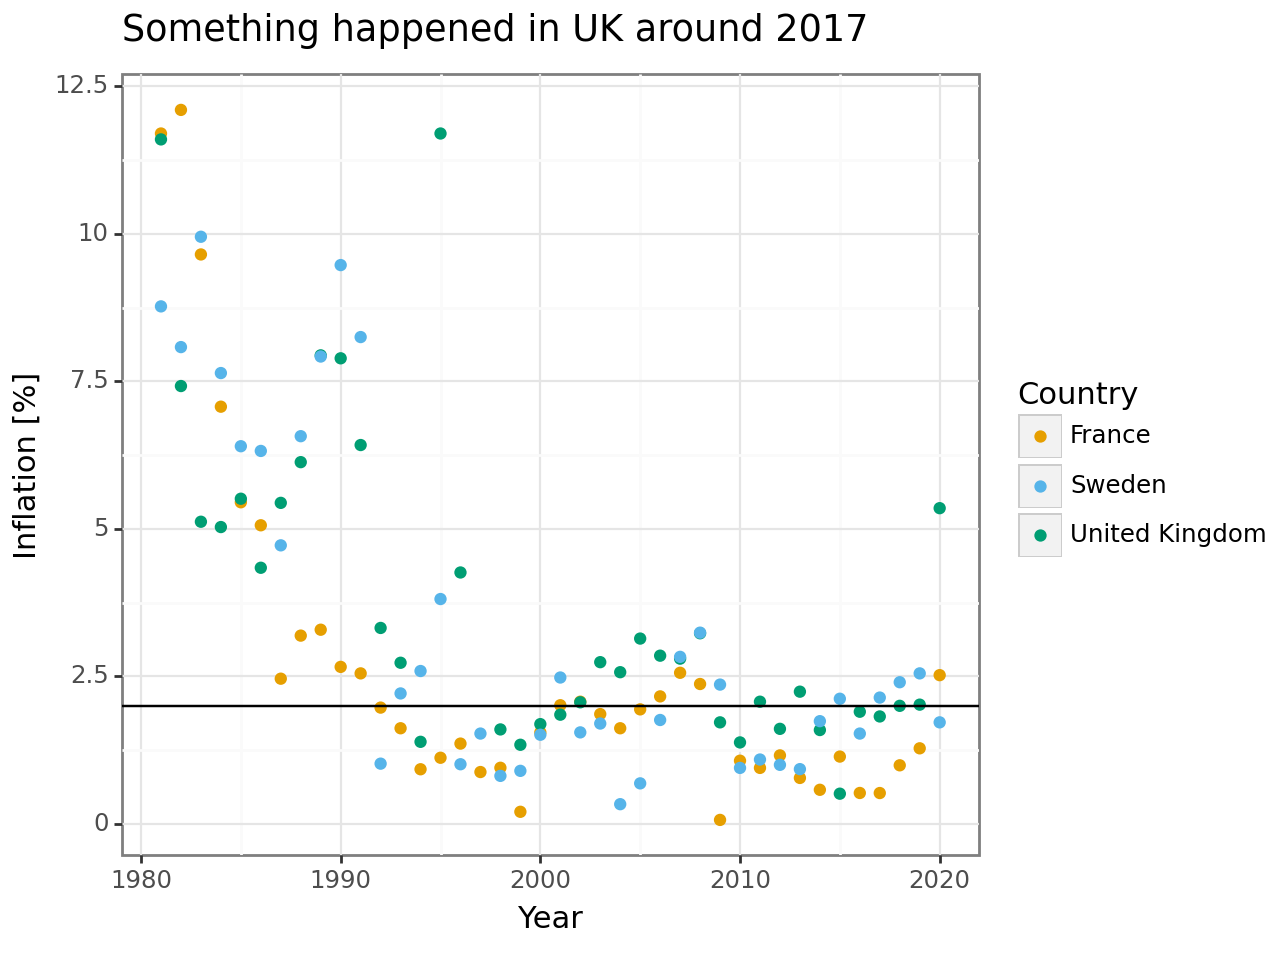

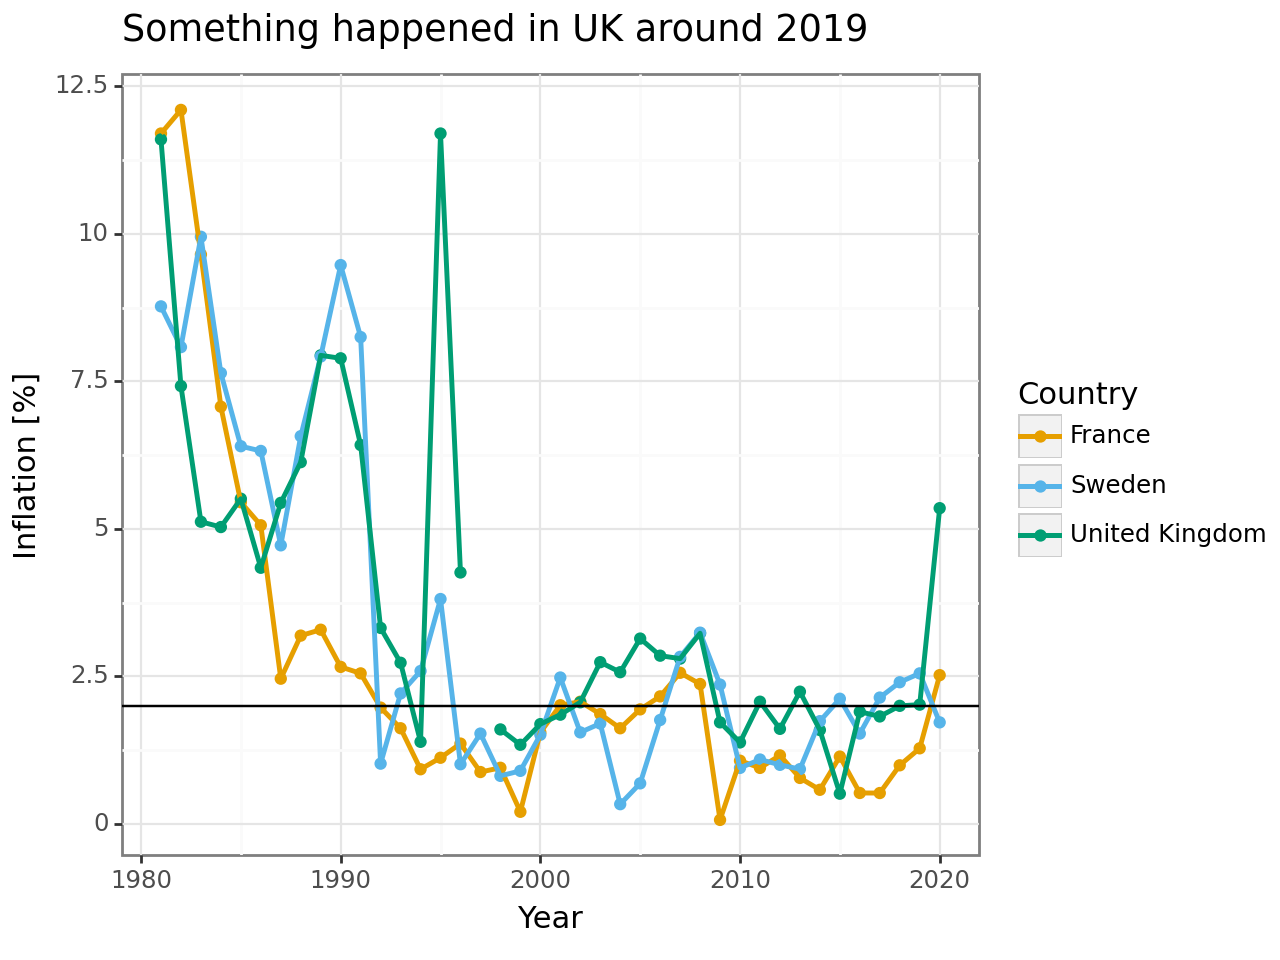

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [3]:
data_inflation = pd.read_csv("Data/Inflation.csv")

data_sweden = data_inflation.query("country == 'Sweden'")
p1 = (ggplot(data_sweden, aes("Year", "Inflation"))
    + geom_point(size=1.5)
    + geom_hline(yintercept=2.0)
    + labs(x = "Year", y = "Inflation [%]", title = "From 1992 Swedish inflation has been around 2%")
    + theme_bw())


p2 = (ggplot(data_inflation, aes("Year", "Inflation", color="country"))
    + geom_point(size=1.5)
    + geom_hline(yintercept=2.0)
    + scale_color_manual(values=cbPalette, name = "Country")
    + labs(x = "Year", y = "Inflation [%]", title = "Something happened in UK around 2017")
    + theme_bw())

p3 = (ggplot(data_inflation, aes("Year", "Inflation", color="country"))
    + geom_point(size=1.5)
    + geom_line(size=1.0)
    + geom_hline(yintercept=2.0)
    + scale_color_manual(values=cbPalette, name = "Country")
    + labs(x = "Year", y = "Inflation [%]", title = "Something happened in UK around 2019")
    + theme_bw())


p1.save("Figs/Ex_time_v1.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p2.save("Figs/Ex_time_v2.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p3.save("Figs/Ex_time_v3.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)

[p1, p2, p3]

When working with time series data, and we want to see rate of change, the most efficient approach is often to transform the data in some way. With this approach, we clearly see the difference between France and Sweden.

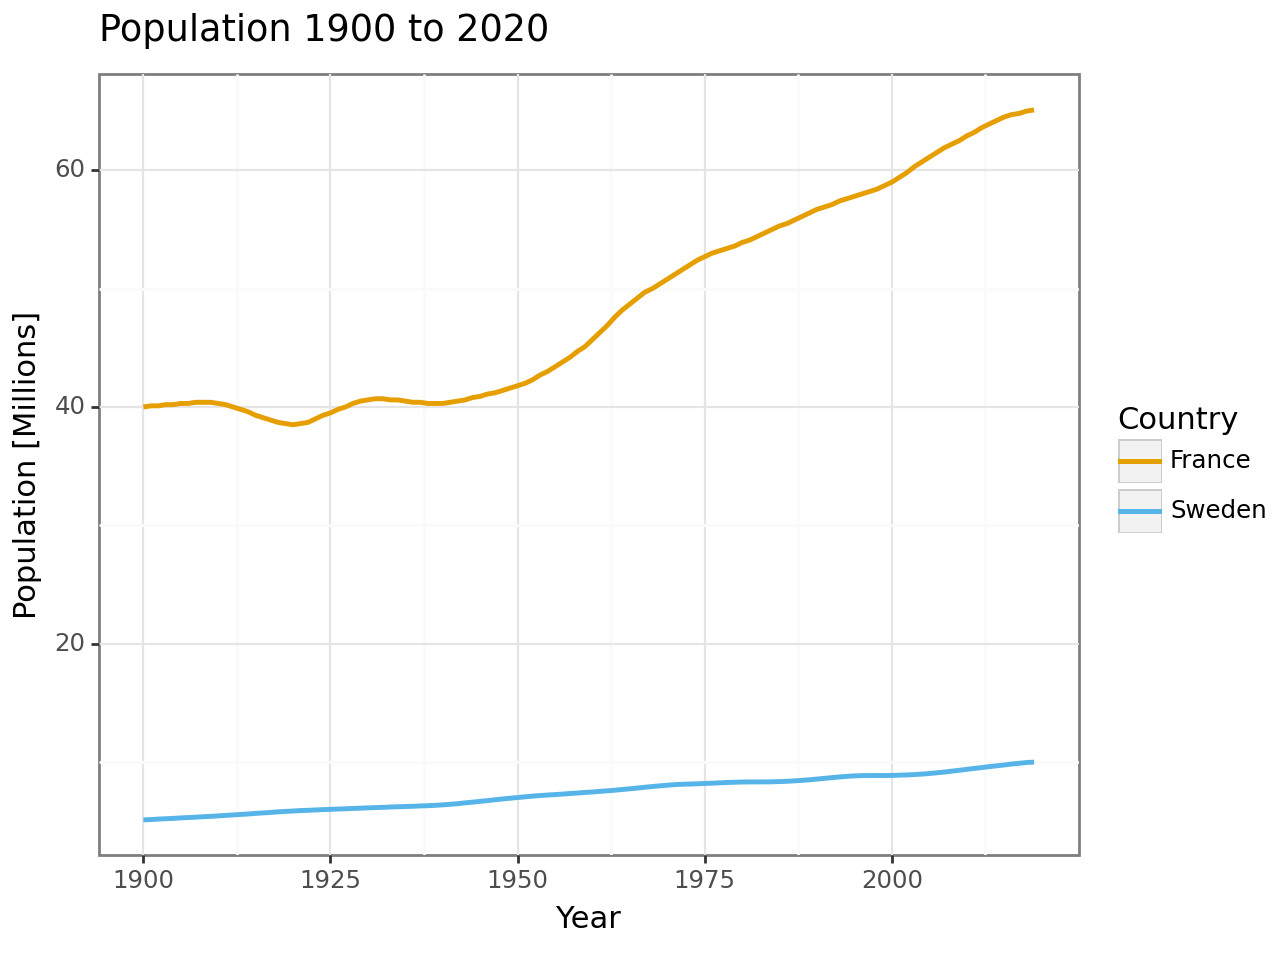

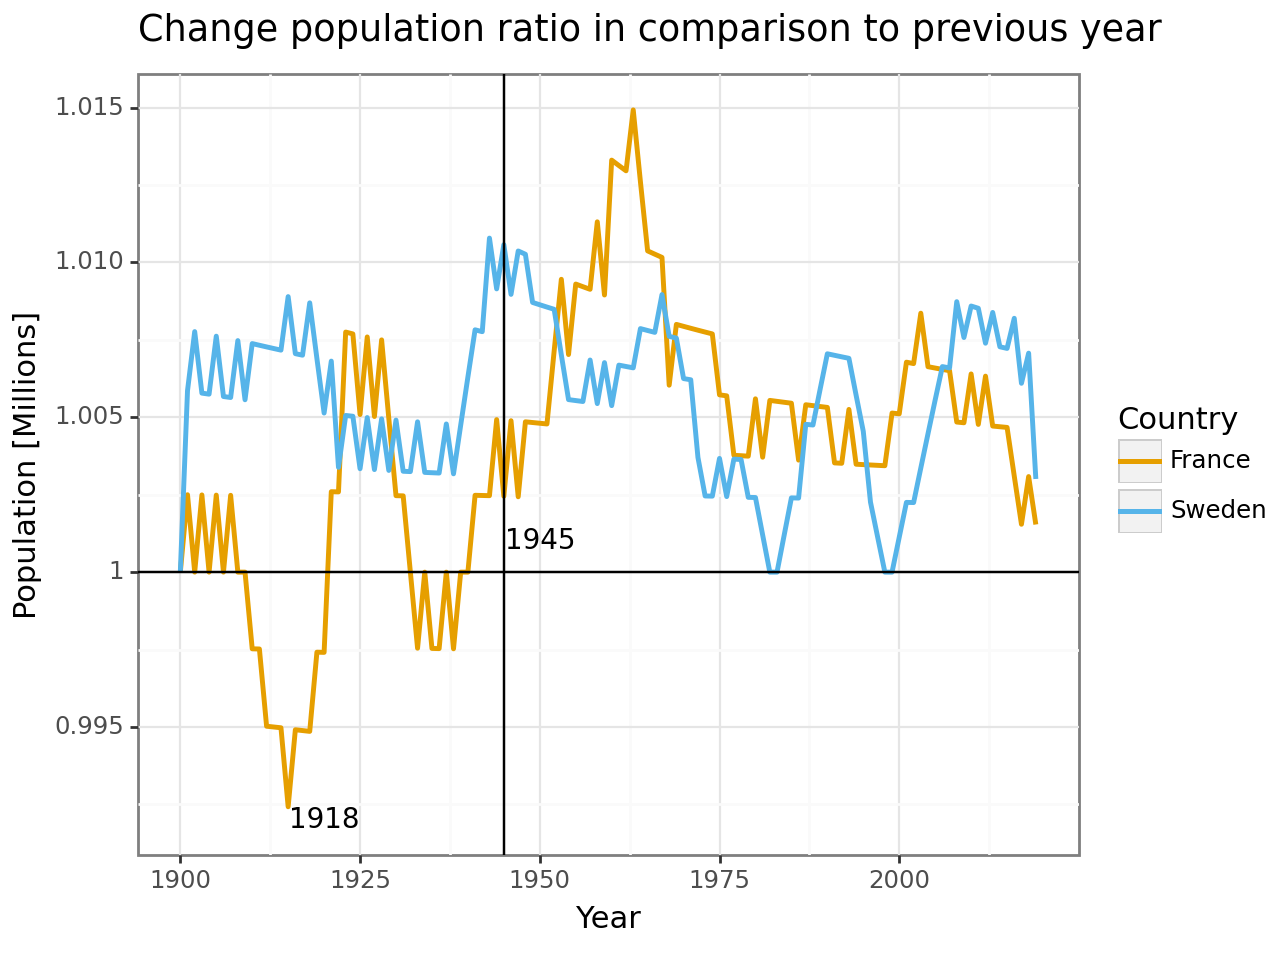

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [4]:
data_sweden = pd.read_csv("Data/Sweden_pop.csv")
data_france = pd.read_csv("Data/France_pop.csv")

data_sweden["Population"] = data_sweden["Population"] / 1e6
data_france["Population"] = data_france["Population"] / 1e6

# Here we compute the change ratio from previous to next year to clearly see if population 
# increase of decreases 
data_sweden["ratio_change"] = np.concatenate(([1.0], data_sweden["Population"][1::].to_numpy() / data_sweden["Population"][0:-1:].to_numpy()), axis=0)
data_france["ratio_change"] = np.concatenate(([1.0], data_france["Population"][1::].to_numpy() / data_france["Population"][0:-1:].to_numpy()), axis=0)

data_tot = pd.concat([data_sweden, data_france])

p1 = (ggplot(data_tot, aes("Year", "Population", color = "country"))
    + geom_line(size=1.0)
    + labs(y = "Population [Millions]", title = "Population 1900 to 2020")
    + scale_color_manual(values=cbPalette, name = "Country")
    + theme_bw())

p2 = (ggplot(data_tot, aes("Year", "ratio_change", color = "country"))
    + geom_line(size=1.0)
    + geom_hline(yintercept=1.0)
    + scale_color_manual(values=cbPalette, name = "Country")
    + annotate("text", x = 1920, y = 0.992, label = "1918", size=10.0)
    + annotate("text", x = 1950, y = 1.001, label = "1945", size=10.0)
    + geom_vline(xintercept=1945)
    + labs(y = "Population [Millions]", title = "Change population ratio in comparison to previous year")
    + theme_bw())

p1.save("Figs/Change_v1.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p2.save("Figs/Change_v2.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)

[p1, p2]


When working with exponentially growing data, a log axis might and often is crucial.

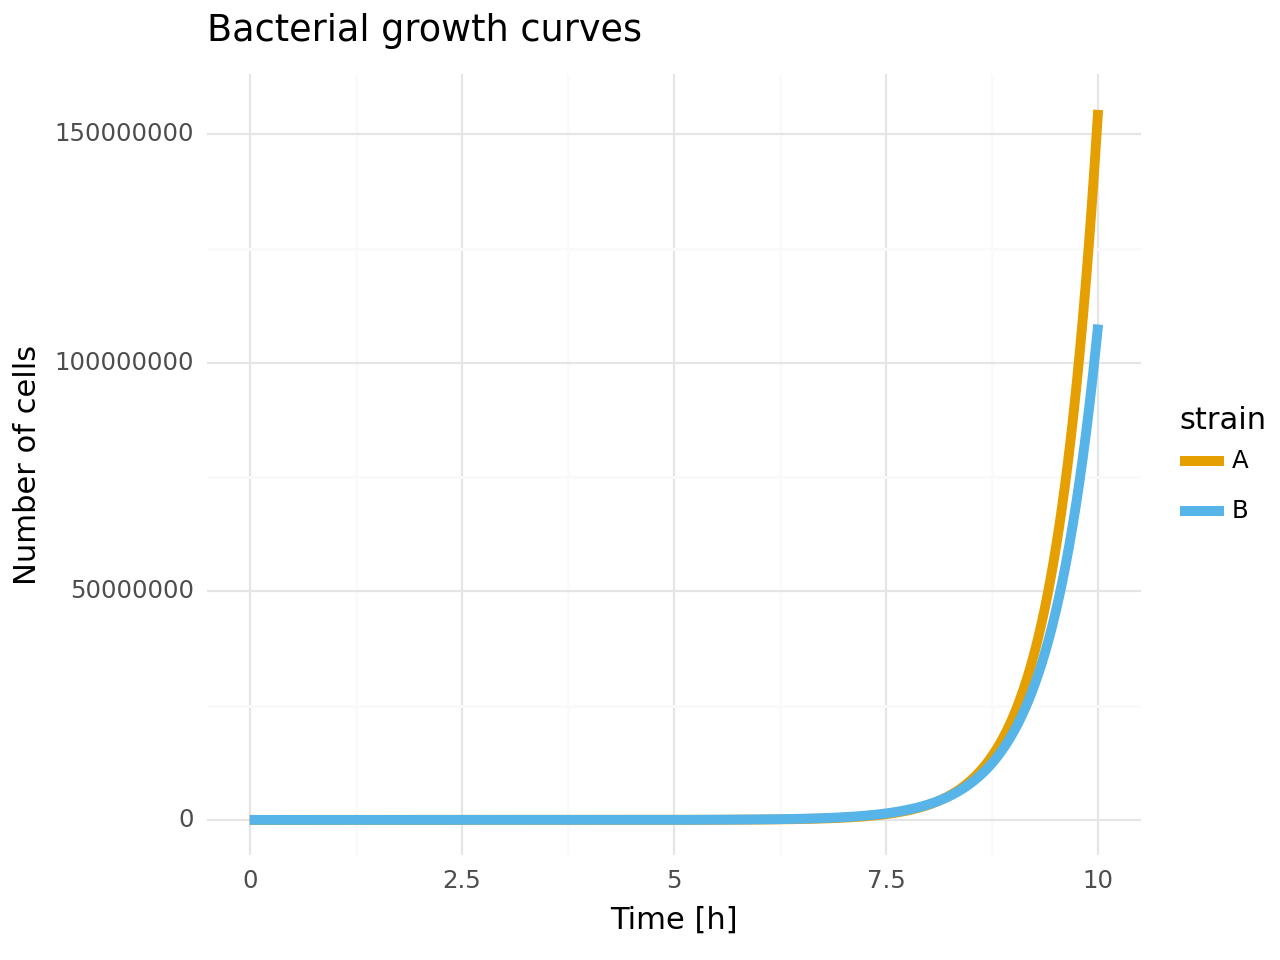

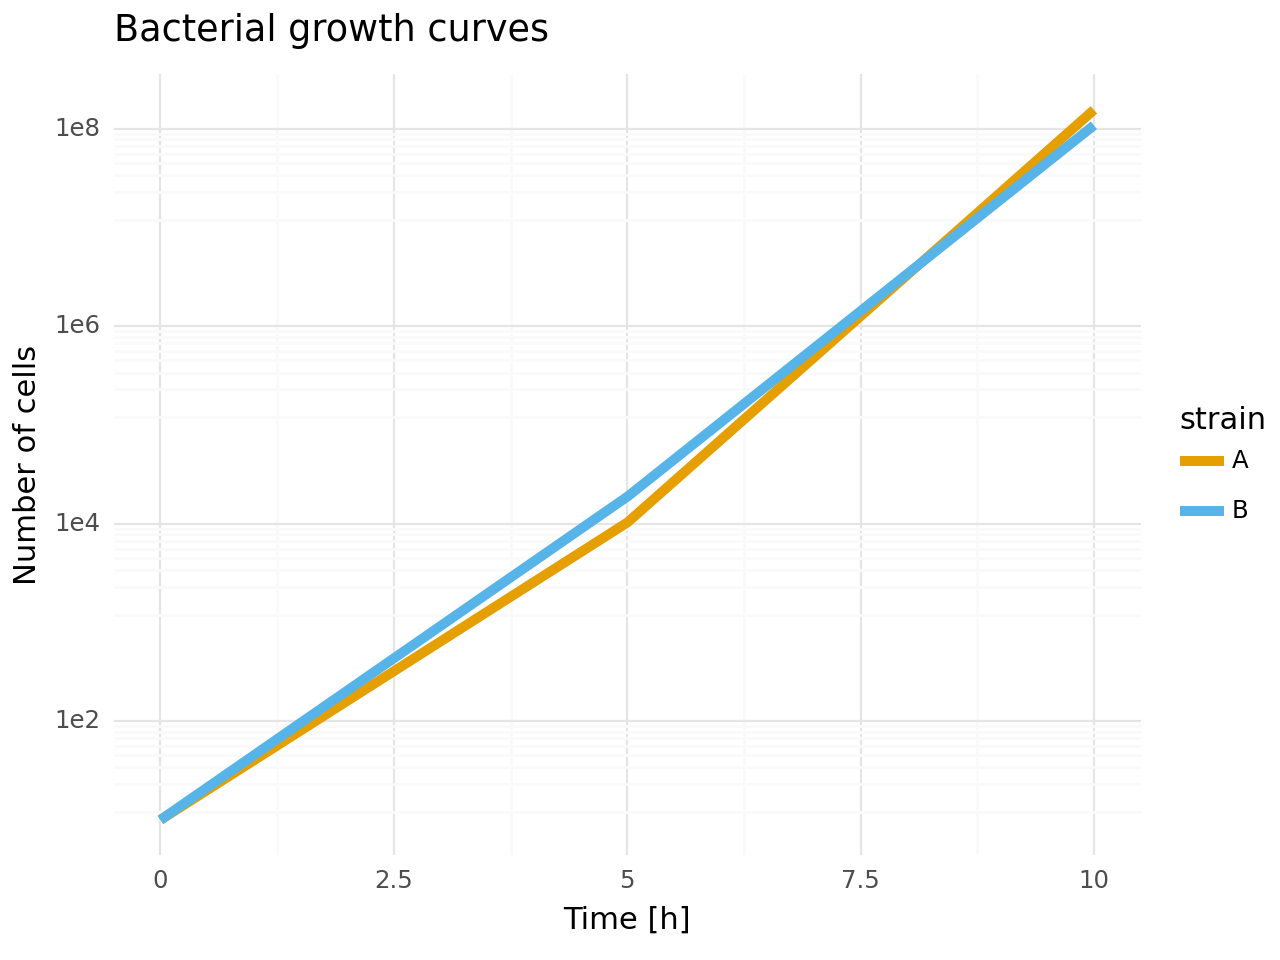

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [5]:
data_growth = pd.read_csv("Data/Growth_rate.csv")

p1 = (ggplot(data_growth, aes("t", "N", color = "strain"))
    + geom_line(size=2.0)
    + scale_color_manual(values=cbPalette)
    + labs(x = "Time [h]", y = "Number of cells", title = "Bacterial growth curves")
    + theme_minimal())

p2 = (ggplot(data_growth, aes("t", "N", color = "strain"))
    + geom_line(size=2.0)
    + scale_y_log10()
    + scale_color_manual(values=cbPalette)
    + labs(x = "Time [h]", y = "Number of cells", title = "Bacterial growth curves")
    + theme_minimal())

p1.save("Figs/Growth_rate_v1.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p2.save("Figs/Growth_rate_v2.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
[p1, p2]

And when working with many categories, do not underestimate the power of facets:

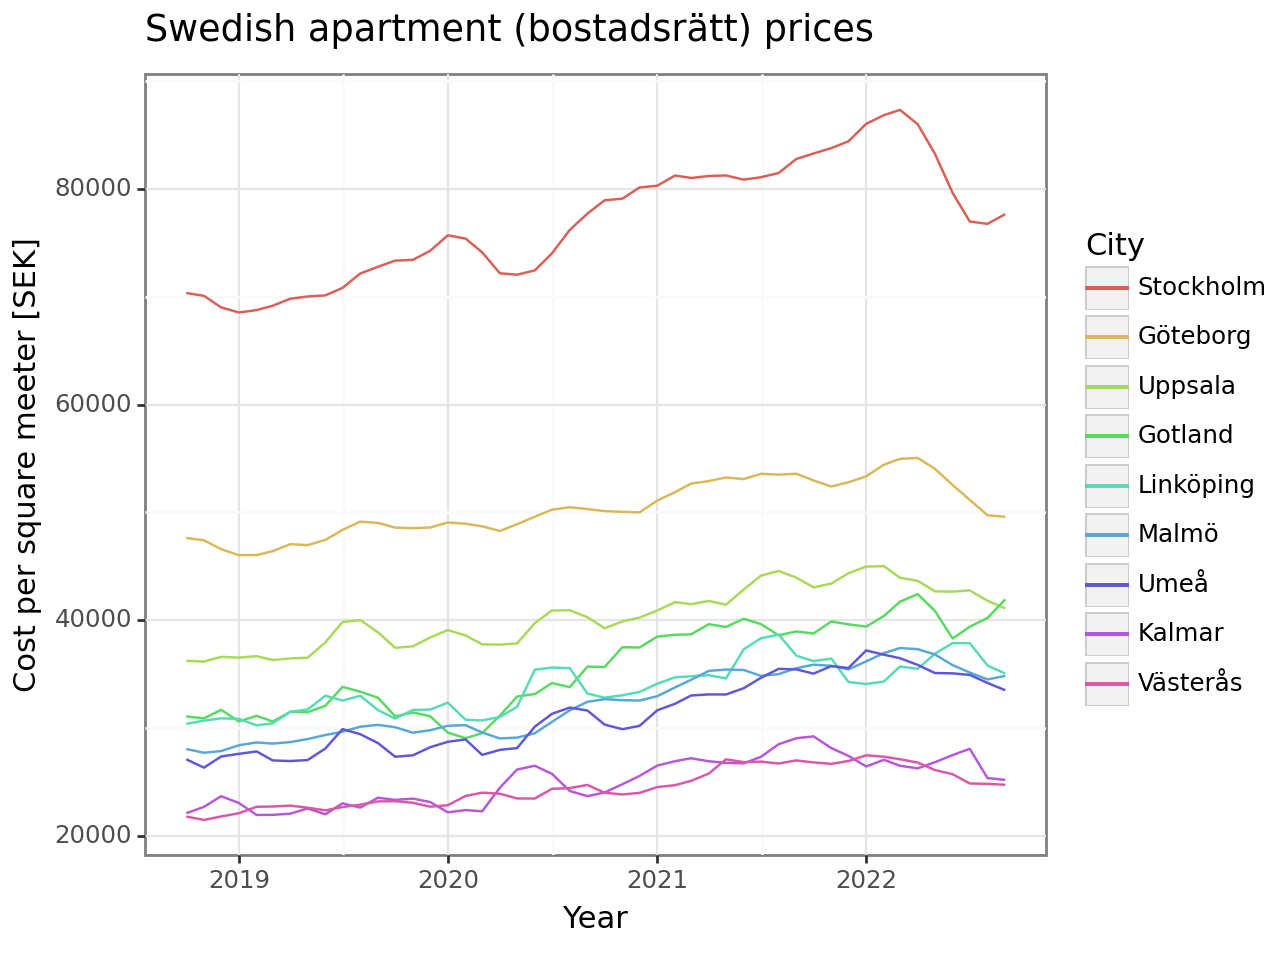

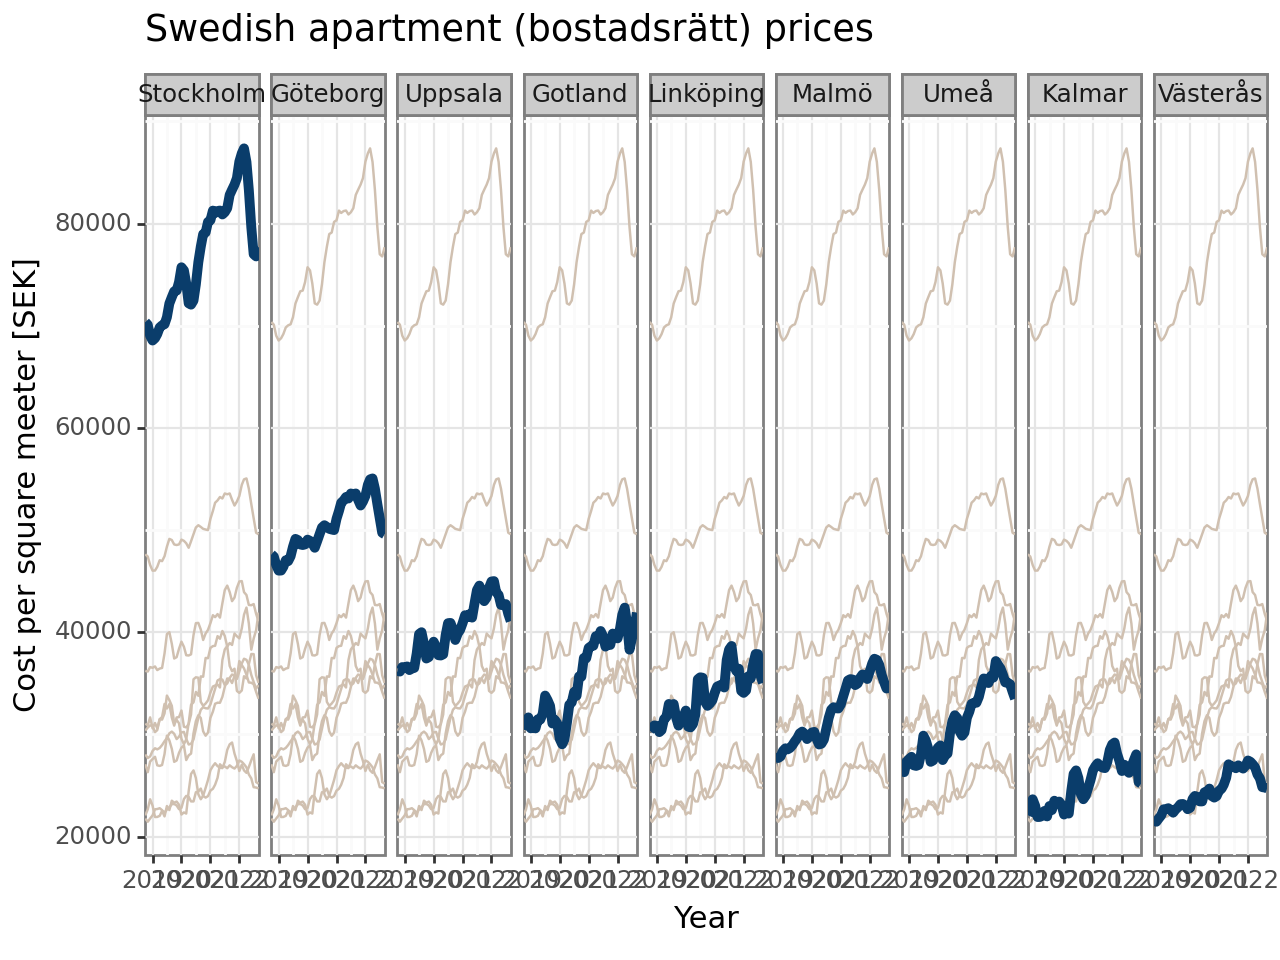

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [6]:
data_housing = pd.read_csv("Data/Housing_sweden.csv")
data_housing = data_housing.assign(City=pd.Categorical(data_housing["City"], 
                                                       categories=["Stockholm", "Göteborg", "Uppsala", "Gotland", "Linköping", "Malmö", "Umeå", "Kalmar", "Västerås"]))

df2 = data_housing.copy() # Create a copy for the facet
df2["City_copy"] = df2["City"]
df2 = df2.drop("City", axis=1)

p1 = (ggplot(data_housing, aes("Månad", "Cost", color = "City"))
    + geom_line(aes(group="City"))
    + scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y'))
    + labs(x = "Year", y = "Cost per square meeter [SEK]", title = "Swedish apartment (bostadsrätt) prices")
    + theme_bw())


p2 = (ggplot(data_housing, aes("Månad", "Cost"))
    + geom_line(data=df2, mapping=aes(x="Månad", y="Cost", group="City_copy"), size=0.5, color=col_highlight[0])
    + geom_line(aes(group="City"), size=2.0, color=col_highlight[1])
    + facet_wrap("~City", nrow=1)
    + labs(x = "Year", y = "Cost per square meeter [SEK]", title = "Swedish apartment (bostadsrätt) prices")
    + scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y'), expand=(0, 0))
    + theme_bw())

p1.save("Figs/Housing.png", width=BASE_WIDTH*1.0, height=BASE_HEIGHT)
p2.save("Figs/Housing_nice.png", width=BASE_WIDTH*2.5, height=BASE_HEIGHT)
[p1, p2]

## Associations 

Often when working with data, we are interested in identifying associations, but, it should always be remembered that correlation is not causation.

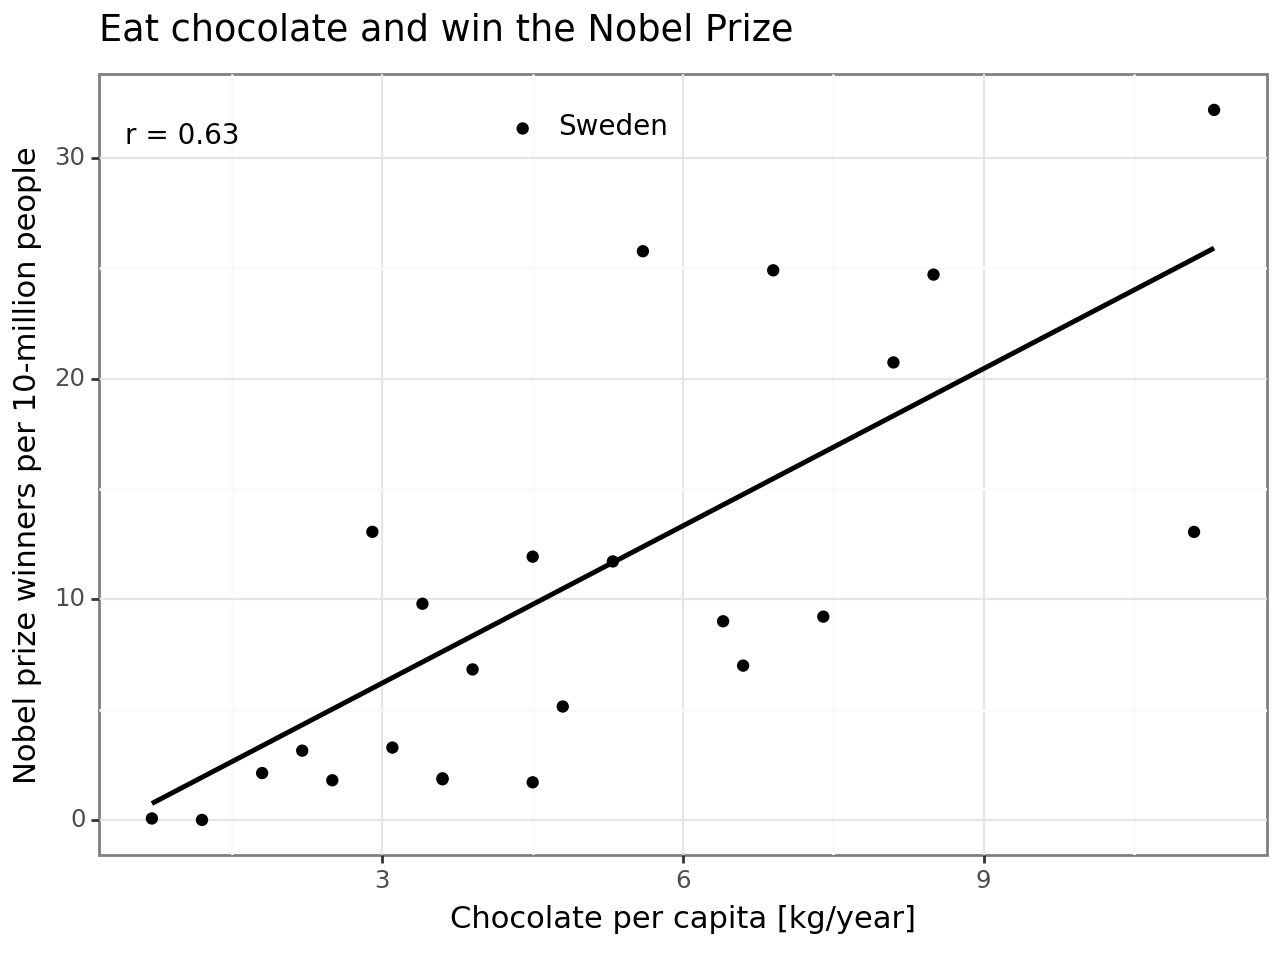

<Figure Size: (640 x 480)>

In [7]:
data1 = pd.DataFrame({"Country" : ["Australia", "Austria", "Belgium", "Brazil", "Canada", "China", "Croatia", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Japan", "Netherlands", "Norway", "Poland", "Portugal", "Romania", "Spain", "Sweden", "Switzerland", "UK", "USA"],
                      "Chocolate_consumption" : [4.8, 8.5, 6.4, 1.2, 3.9, 0.7, 6.6, 6.9, 8.8, 7.4, 3.4, 11.1, 2.5, 2.9, 8.8, 3.1, 1.8, 4.5, 5.6, 2.2, 3.6, 3.6, 4.5, 4.4, 11.3, 8.1, 5.3],
                      "Coffe_consumption" : [2.6, 5.5, 4.9, 4.8, 3.4, 1.2, 3.8, 5.3, 4.2, 9.6, 3.2, 5.2, 2.4, 3.1, 2.1, 3.4, 1.5, 6.7, 7.2, 3.1, 2.6, 1.9, 3.0, 9.8, 3.9, 1.7, 3.1],
                      "Nobel_laureates" : [12, 21, 10, 0, 24, 9, 3, 14, 0, 5, 63, 108, 2, 13, 7, 20, 27, 20, 13, 12, 2, 4, 8, 30, 26, 133, 375], 
                      "Pop2013" : [23342553, 8495145, 11104476, 200361925, 35181704, 1385566537, 4289714, 5619096, 1287251, 5426323, 64291280, 82726626, 11127990, 9954941, 4627173, 60990277, 127143577, 16759229, 5042671, 38216635, 10608156, 21698585, 46926963, 9571105, 8077833, 64130000, 320050716]})

data1["Wins_norm"] = data1["Nobel_laureates"] / (data1["Pop2013"]) * 1e7
data1 = data1.query("Country != 'Ireland'")
data1 = data1.query("Country != 'Estonia'")

# R-value is a linear regression goodness of fit value 
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(data1["Wins_norm"], data1["Chocolate_consumption"])

p1 = (ggplot(data1, aes("Chocolate_consumption", "Wins_norm"))
    + geom_point()
    + geom_smooth(method="lm", se=False)
    + annotate("text", x = 1, y = 31, label = "r = 0.63", size=10.0)
    + annotate("text", x = 5.3, y = 31.4, label = "Sweden", size=10.0)
    + labs(x = "Chocolate per capita [kg/year]", y = "Nobel prize winners per 10-million people", title = "Eat chocolate and win the Nobel Prize")
    + theme_bw())

p1.save("Figs/Chocolate.png", width=BASE_WIDTH, height=BASE_HEIGHT)

p1 

Now let us see if we can use our skills to hunt down **why** Finland is such a happy country.

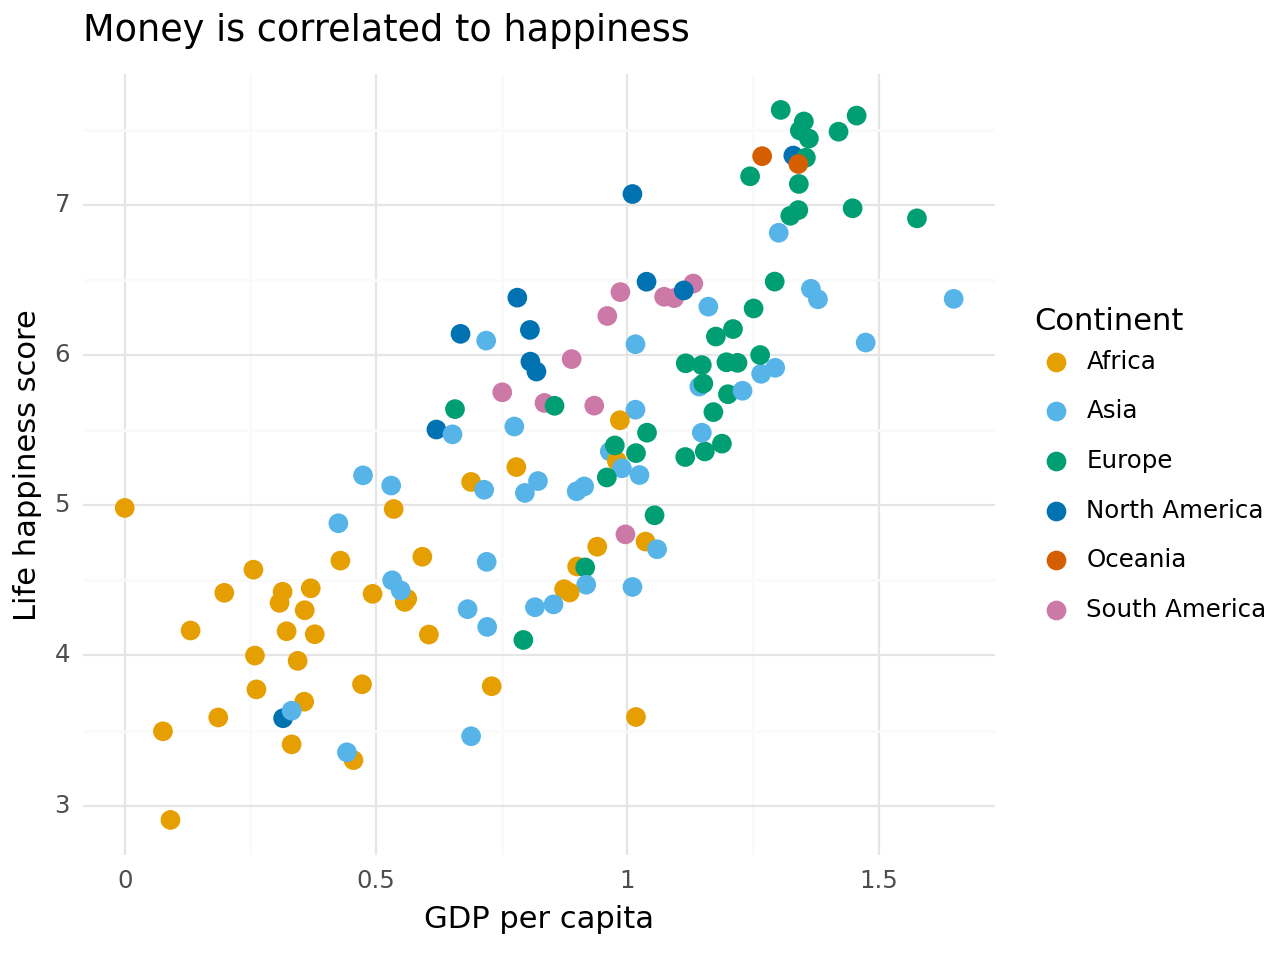

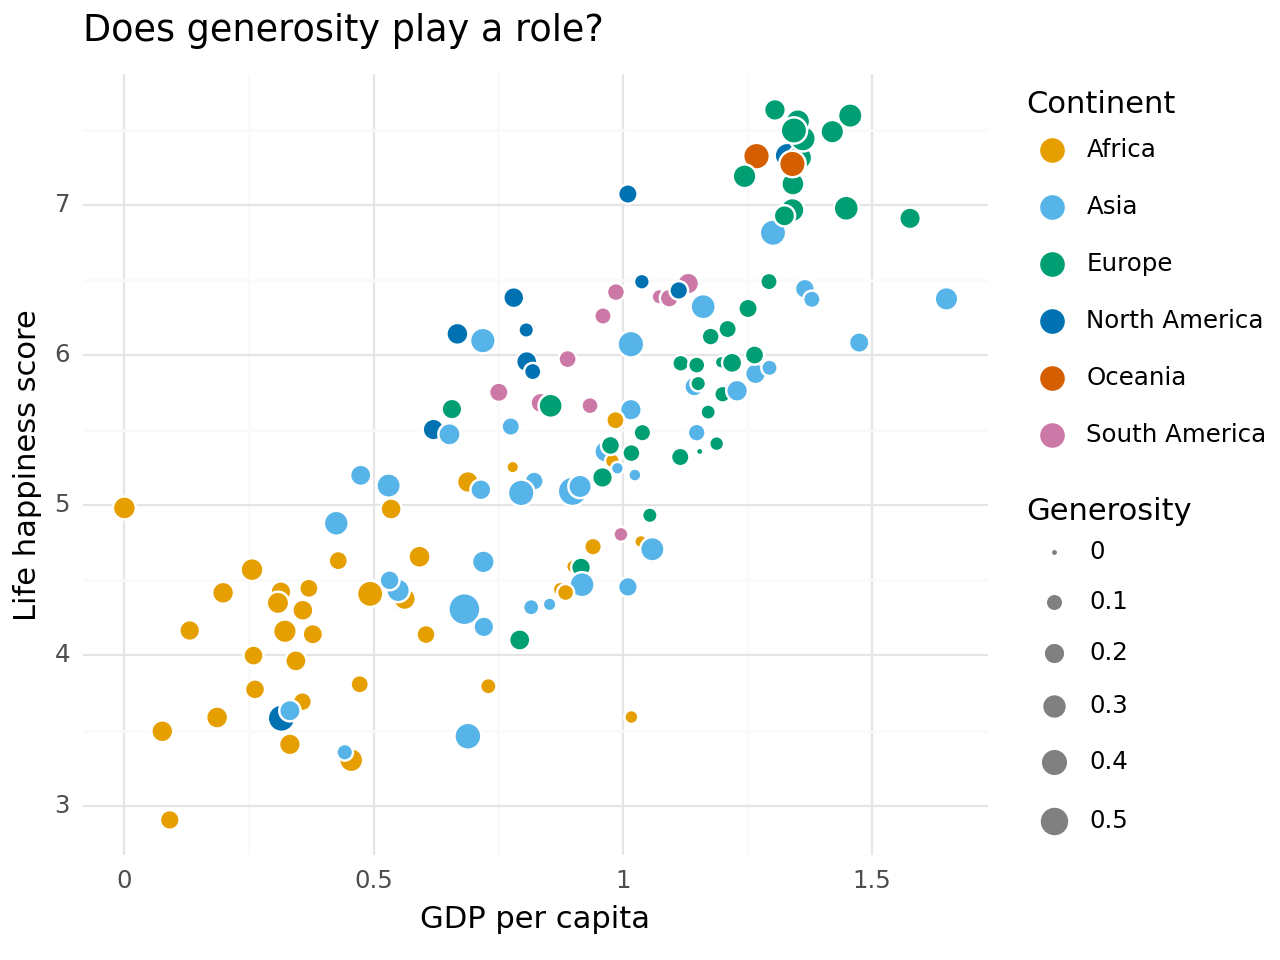

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [8]:
data_2018 = pd.read_csv("Data/World_2018.csv")

p1 = (ggplot(data_2018, aes("GDP_per_capita", "Score", color="continent"))
    + geom_point(size=3.0)
    + scale_color_manual(values=cbPalette, name = "Continent")
    + labs(x = "GDP per capita", y = "Life happiness score", title = "Money is correlated to happiness")
    + theme_minimal())

# Let see if we can include additional variable
p2 = (ggplot(data_2018, aes("GDP_per_capita", "Score", size="Generosity", fill="continent"))
    + geom_point(color="white")
    + labs(x = "GDP per capita", y = "Life happiness score", title = "Does generosity play a role?")
    + scale_fill_manual(values=cbPalette, name = "Continent")
    + theme_minimal()
    + guides(fill=guide_legend(override_aes={"size": 5}), # This fixes the size of the legend-dots
             size=guide_legend(override_aes={"fill": "grey"}))) # This fixes the fill of the grey dots 

p1.save("Figs/Scatter_ex1.png", width=BASE_WIDTH, height=BASE_HEIGHT)
p2.save("Figs/Scatter_ex2.png", width=BASE_WIDTH, height=BASE_HEIGHT)

[p1, p2]

With more than two variables, it is pretty hard to obtain any conclusion from a scatter plot. We can use the scatter plot matrix instead. Below, we will build the matrix ourselves, but in practice there are many plotting libraries which have natural support for these in [Python](https://plotly.com/python/splom/) and [R](https://www.r-bloggers.com/2021/06/ggpairs-in-r-a-brief-introduction-to-ggpairs/).

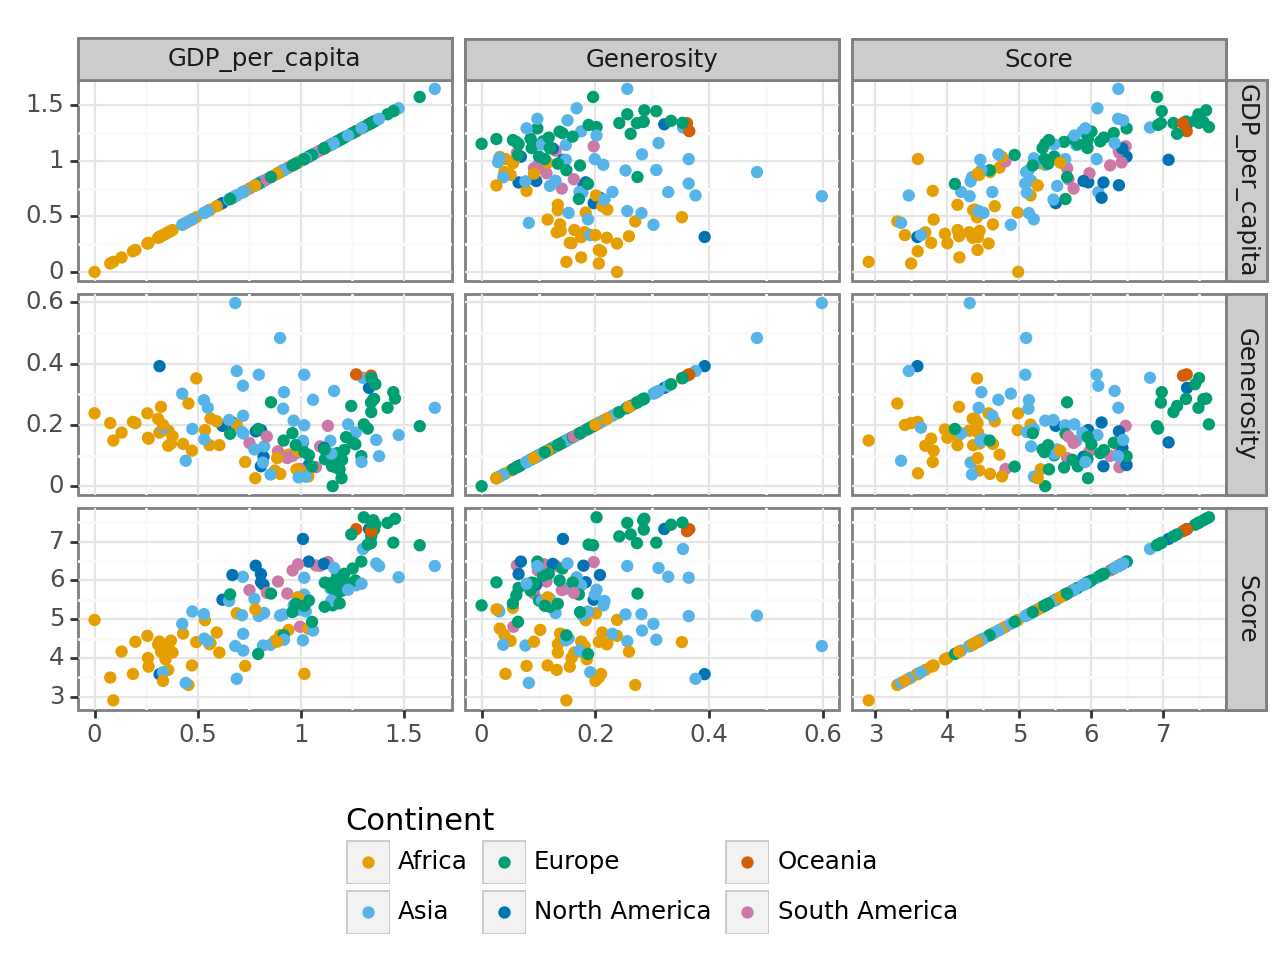

<Figure Size: (640 x 480)>

In [9]:
# Here we build a DataFrame we can turn into a score matrix 
var_plot = ["GDP_per_capita", "Score", "Generosity"]
df_tmp1 = data_2018[["name", "continent"] + var_plot]
df_tmp = df_tmp1.melt(id_vars=["name", "continent"], value_vars=var_plot, value_name="val_x", var_name="var_x") 
df_tmp = df_tmp.merge(df_tmp1)
df_plot = df_tmp.melt(id_vars=["name", "continent", "var_x", "val_x"], value_vars=var_plot, value_name="val_y", var_name="var_y")

# We can create the matrix using facets 
p = (ggplot(df_plot, aes("val_x", "val_y", color="continent"))
    + geom_point()
    + scale_color_manual(values=cbPalette, name = "Continent")
    + facet_grid("var_y ~ var_x", 
                 scales="free")
    + labs(x = "", y = "")
    + theme_bw()
    + theme(legend_position="bottom"))

p.save("Figs/Scatter_matrix.png", width=BASE_WIDTH, height=BASE_HEIGHT)
# For homework you should add two additional variables
p

A scatter matrix can become a mess if we have too many variables. Here, a heatmap might be the better choice. Plotnine (and ggplot in R) do not support heatmaps. Hence, we must use another library (I recommend seaborn: see below).

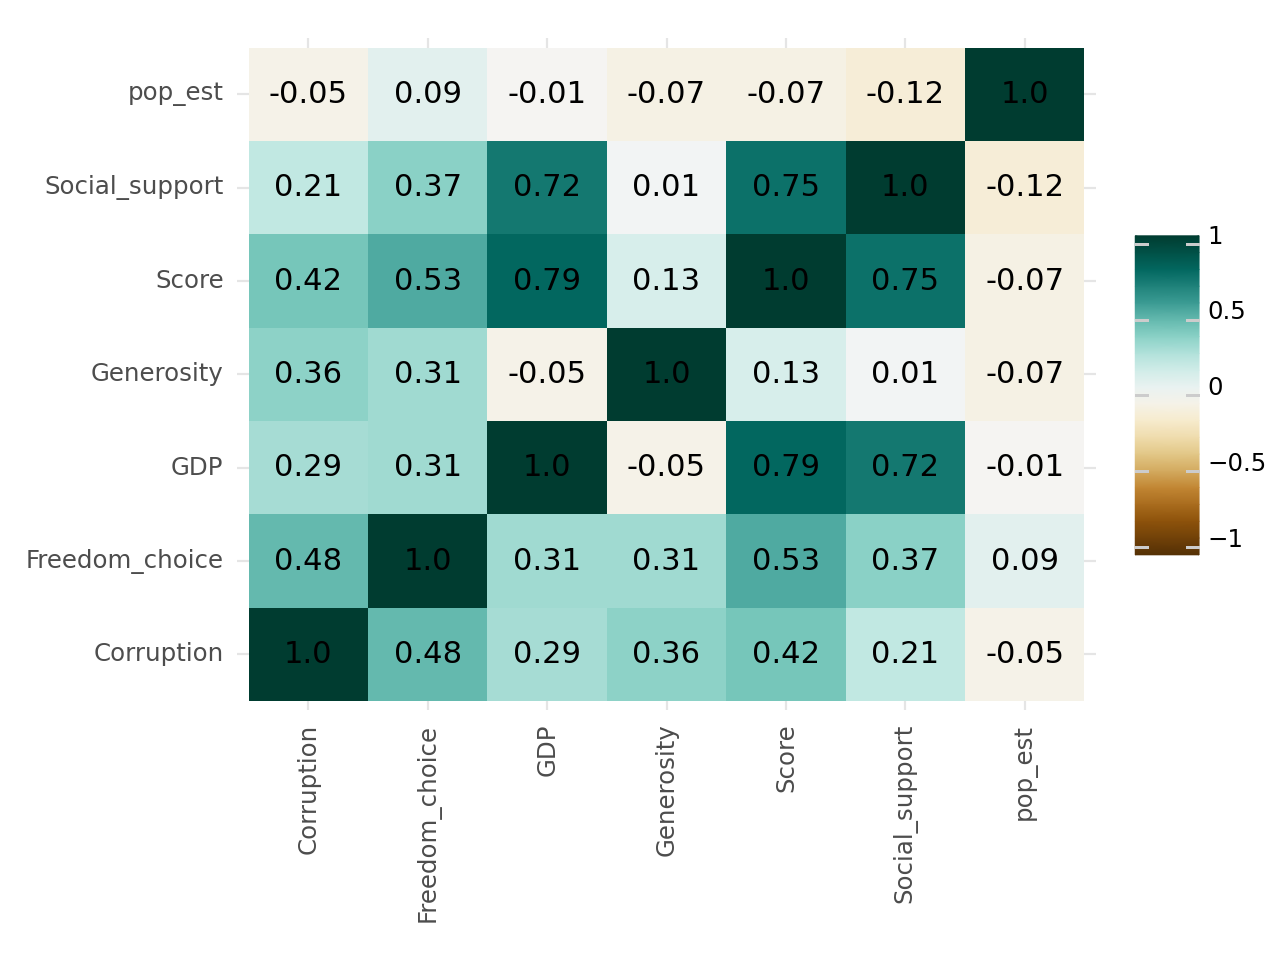

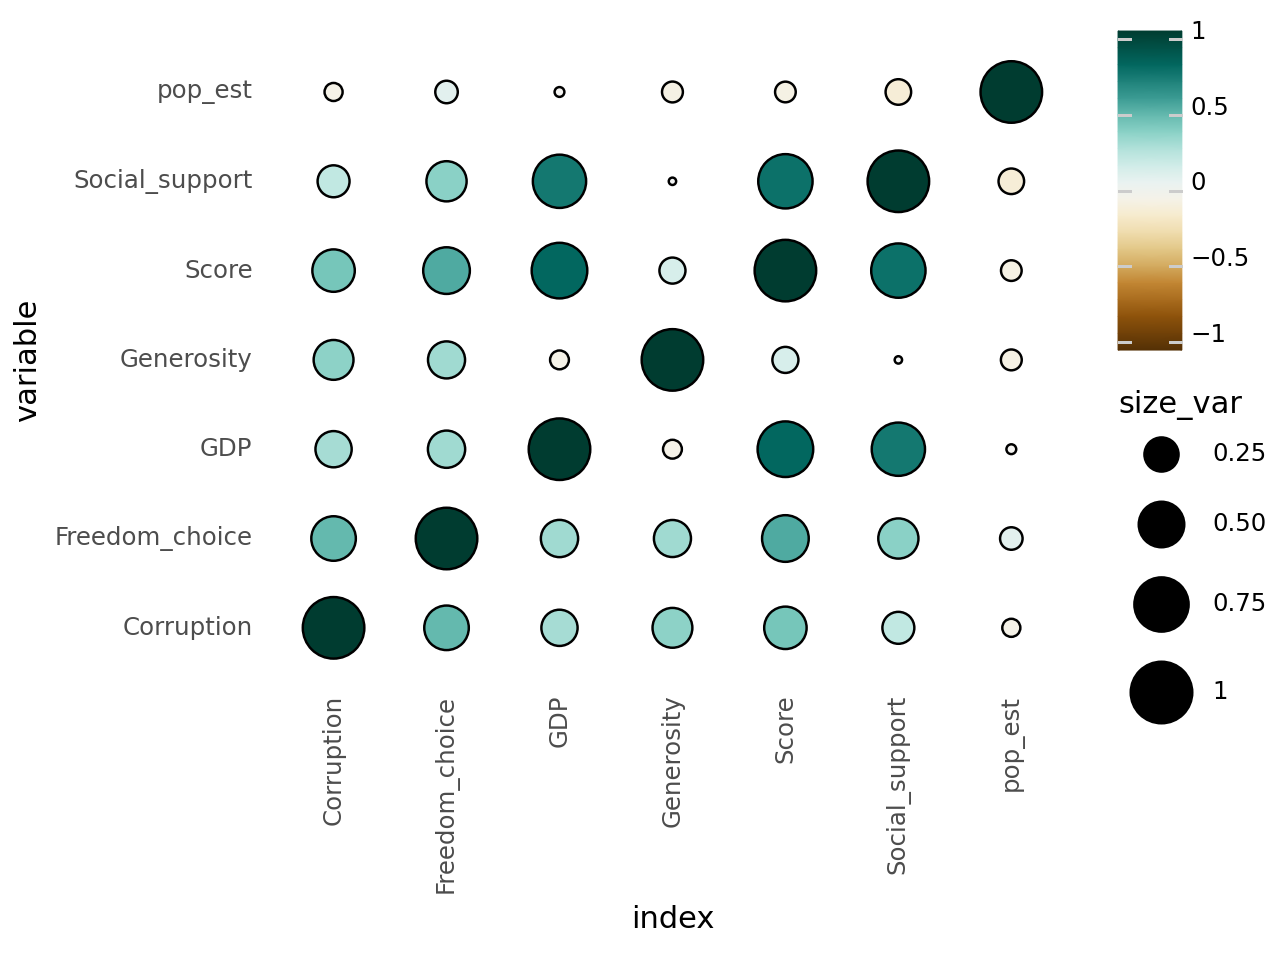

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [10]:
var_plot = ["GDP_per_capita", "Score", "Generosity", "Social_support", "Freedom_to_make_life_choices", "Perceptions_of_corruption", "pop_est"]
df_tmp = data_2018[var_plot]
df_tmp = df_tmp.rename(columns={"GDP_per_capita" : "GDP", 
                       "Freedom_to_make_life_choices" : "Freedom_choice", 
                       "Perceptions_of_corruption" : "Corruption"})

_data_corr = df_tmp.corr().melt(ignore_index=False).reset_index()
_data_corr["lab_text"] = np.round(_data_corr["value"], 2)
p1 = (ggplot(_data_corr, aes("index", "variable"))
 + geom_tile(aes(fill = "value"))
 + scale_fill_cmap("BrBG", limits=[-1, 1], name=" ")
 + labs(x = "", y = "")
 + geom_label(aes(label = str("lab_text")), label_size=0.0, fill=None)
 + theme_minimal()
 + theme(axis_text_x=element_text(angle=90)))

_data_corr["size_var"] = np.abs(_data_corr["value"])
p2 = (ggplot(_data_corr, aes("index", "variable"))
 + geom_point(aes(fill = "value", size="size_var"))
 + scale_fill_cmap("BrBG", limits=[-1, 1], name=" ")
 + scale_size(range=[1, 12])
 + theme_minimal()
 + theme(axis_text_x=element_text(angle=90), 
         panel_grid=element_blank()))

p1.save("Figs/Corr_mat1.png", width=BASE_WIDTH, height=BASE_HEIGHT)
p2.save("Figs/Corr_mat1.svg", width=BASE_WIDTH, height=BASE_HEIGHT)
[p1, p2]

However, it is important to keep in mind that lack of correlation does not mean lack of relationship.

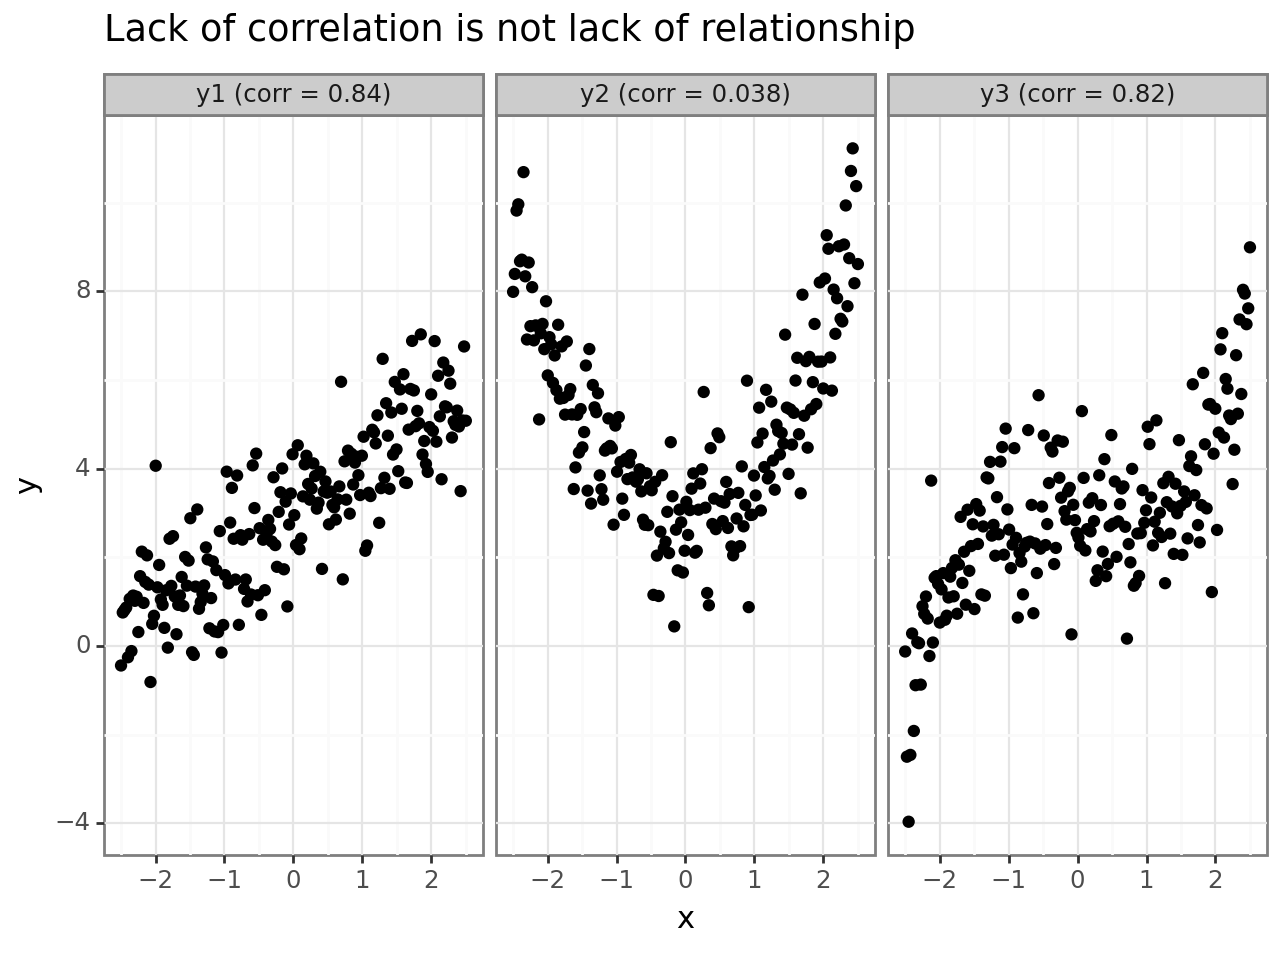

<Figure Size: (640 x 480)>

In [11]:
x_data = np.linspace(-2.5, 2.5, 200)
y_data1 = x_data + 3.0 + np.random.normal(size=200)
y_data2 = x_data**2 + 3.0 + np.random.normal(size=200)
y_data3 = 0.05*x_data**5 + 3.0 + np.random.normal(size=200)

df = pd.DataFrame({"x" : x_data, "y1 (corr = 0.84)" : y_data1, "y2 (corr = 0.038)" : y_data2, "y3 (corr = 0.82)" : y_data3})
data_plot = df.melt(id_vars = ["x"], value_vars=["y1 (corr = 0.84)", "y2 (corr = 0.038)", "y3 (corr = 0.82)"], value_name="y", var_name="Dataset")

p = (ggplot(data_plot, aes("x", "y"))
    + geom_point()
    + facet_wrap("~Dataset")
    + labs(title = "Lack of correlation is not lack of relationship")
    + theme_bw())

p.save("Figs/Ex_corr_fail.png", width=BASE_WIDTH*2.0, height=BASE_HEIGHT)

p